In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import yfinance as yf
import math
import matplotlib.pyplot as plt
import torch.nn.functional as F
import sklearn.model_selection
import torch.utils.data as data

In [112]:
#Extracting Data
companies = ["NVDA","MSFT","AAPL","GOOG"]
#Getting ticker object

data_standard = []
for c in companies:
    ticker = yf.Ticker(c)

    #Get historic data for the last 5 years
    history = ticker.history(start="2020-1-01",end="2024-1-01",actions=True)

    #Extract open,volume and dividends
    stock_data = history[["Open","Volume"]]

  

    #Convert to numpy
    data_standard_company = stock_data.to_numpy()

    #And concat it with the rest
    if(len(data_standard)>0):
        data_standard = np.concatenate((data_standard,data_standard_company),axis =1)
    else:
        data_standard = data_standard_company


print(data_standard)

[[5.94287237e+00 2.37536000e+08 1.51289108e+02 ... 1.35480400e+08
  6.66811363e+01 2.81320000e+07]
 [5.85201811e+00 2.05384000e+08 1.50850838e+02 ... 1.46322800e+08
  6.69947639e+01 2.37280000e+07]
 [5.78281947e+00 2.62636000e+08 1.49669313e+02 ... 1.18387200e+08
  6.71011432e+01 3.46460000e+07]
 ...
 [4.94889795e+01 2.33648000e+08 3.69495781e+02 ... 4.80877000e+07
  1.41986003e+02 1.72884000e+07]
 [4.96209217e+01 2.46587000e+08 3.71156888e+02 ... 3.40499000e+07
  1.41011814e+02 1.21925000e+07]
 [4.97908442e+01 3.89293000e+08 3.71779807e+02 ... 4.26288000e+07
  1.39848706e+02 1.48727000e+07]]


In [113]:
#Creating a dataset by taking the last n values
def create_dataset(dataset,lookback):
    X = []
    y=[]

    for i in range(len(dataset)-lookback-1):
        feature = dataset[i:i+lookback]
        target = dataset[i+lookback+1]
        X.append(feature)
        y.append(target)
    
    return torch.FloatTensor(X),torch.FloatTensor(y)

In [114]:
#Create dataset
lookback =30
X,y = create_dataset(data_standard,lookback)

X_train,X_test,y_train,y_test = sklearn.model_selection.train_test_split(X,y,test_size=0.2,random_state=42)

print(X_train.shape)
print(y_train.shape)

torch.Size([780, 30, 8])
torch.Size([780, 8])


In [ ]:

class Trader(nn.Module):
    #Init
    def __init__(self,features:int,hidden_size:int,n_layers:int,mean,std):
        super().__init__()
        self.lstm_layers = nn.ModuleList()
        self.dropout_layers = nn.ModuleList()
        self.mean = mean
        self.std = std


        #The lstms layers with dropout
        for i in range(n_layers):
            in_size =hidden_size
            
            if i ==0:
                in_size = features 

            self.lstm_layers.append(nn.LSTM(input_size=in_size,hidden_size=hidden_size,num_layers=1,batch_first=True))
            self.dropout_layers.append(nn.Dropout(0.2))
        
        #The fully connected model
        self.fc  = nn.Linear(hidden_size,features)       

    #The forward function
    def forward(self,x):
        for lstm,drop in zip(self.lstm_layers,self.dropout_layers):
            x = (x-self.mean)/(self.std)
            x,_ = lstm(x)
            x = drop(x)
        
        x = self.fc(x[:,-1,:])
        return x*self.std + self.mean

       

In [ ]:
#Defining the hyperparameters of our model
trader = Trader(8,128,2,mean,std)
optimizer = optim.Adam(trader.parameters(),lr=1e-3)
loss_fn = nn.MSELoss()

print(X_train.shape)
print(y_train.shape)
loader = data.DataLoader(data.TensorDataset(X_train,y_train),shuffle = True,batch_size = 8)
epochs = 200

torch.Size([780, 30, 8])
torch.Size([780, 8])


In [8]:
for e in range(epochs):
    trader.train()
    
    total_loss = 0
    for X_batch,y_batch in loader:
        y_pred = trader(X_batch)
        loss = loss_fn(y_pred,y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    print(e," Loss is",total_loss)


0  Loss is 51.332232907414436
1  Loss is 37.58071768283844
2  Loss is 34.16729778051376
3  Loss is 32.921339742839336
4  Loss is 33.18348354101181
5  Loss is 32.1002821624279
6  Loss is 30.545806907117367
7  Loss is 30.901489101350307
8  Loss is 29.701259456574917
9  Loss is 29.421016849577427
10  Loss is 28.77856597304344
11  Loss is 28.40212658792734
12  Loss is 28.163376480340958
13  Loss is 28.02542419731617
14  Loss is 27.744779609143734
15  Loss is 26.714177504181862
16  Loss is 26.158804513514042
17  Loss is 25.571423523128033
18  Loss is 24.87675442546606
19  Loss is 25.00182392448187
20  Loss is 24.119453825056553
21  Loss is 23.57879861444235
22  Loss is 23.23117731511593
23  Loss is 22.46445869654417
24  Loss is 22.801153924316168
25  Loss is 21.75351609289646
26  Loss is 21.160543456673622
27  Loss is 20.364196449518204
28  Loss is 20.285137850791216
29  Loss is 19.475631177425385
30  Loss is 19.099777828902006
31  Loss is 18.566152185201645
32  Loss is 18.29282781481743
33

In [60]:
#Generate a sequence
def generate_sequence(X,model,lookahead):
    generated = []
    model.eval()
    for i in range(lookahead):
        y = model(X.unsqueeze(0))
        X = torch.cat([X[1:,:],y],dim=0)
        

        #Numpy representation
        y_numpy = y.squeeze(0).detach().numpy()
        generated.append(y_numpy)
    return np.array(generated)

[-1.0483702 -1.0943699 -1.0788771]


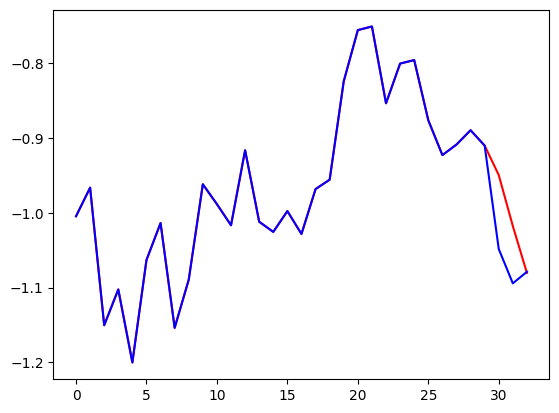

In [67]:
lookahead = 3
#Display sample graph
company_id = 1


index = 177

inp = X[index]

combined = inp[:,company_id*2].numpy()
actual = data_standard[index + lookback:index+lookback+lookahead,company_id*2]
generated = generate_sequence(inp,trader,lookahead)[:,company_id*2]
real = np.concatenate((combined,actual))
predicted = np.concatenate((combined,generated))

print(generated)
plt.plot(real,color='r')
plt.plot(predicted,color='b')

In [95]:
#Testing Simulation
#Simulating the market for training
money = 5000
stocks = [0,]*len(companies)

values = []

price_history = []

for x in X:
    price_indices = x[:,[2*i for i in range(0,len(companies))]]
    means = mean[[2*i for i in range(0,len(companies))]]
    stds = std[[2*i for i in range(0,len(companies))]]

    #Actual last price
    prices = (price_indices*stds+means).numpy()[-1]
    
    predictions = generate_sequence(x,trader,3)[:,[2*i for i in range(0,len(companies))]]
    predicted_indices = np.mean(predictions,axis=0)
    predicted = predicted_indices*stds+means
    changes = (predicted-prices)/prices
    

    contri  = [] 
    div = 0
    #We sell all the stocks which are going down and calculate how much to reinvest
    for i in range(len(changes)):
        #If there is a positive change
        if(changes[i]>0):
            contri.append(changes[i])
            div += changes[i]
        else:
            #Stock is going down... Sell it 
            money += stocks[i]*prices[i]
            stocks[i] = 0
            contri.append(0)

    if(div!=0):
        spent = 0
        #Reinvest money
        for i in range(len(contri)):
            #Money to invest
            m = (contri[i]/div)*money
            new_stocks = (m//prices[i])
            stocks[i] += new_stocks
            spent += new_stocks*prices[i]
        money -= spent
    
    #Compute valuation
    val = money + np.multiply(stocks,prices).sum()
    values.append(val)

    price_history.append(prices)

print(val)


 


C:\Users\Dell\AppData\Local\Temp\ipykernel_17684\2979163769.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  prices = (price_indices*stds+means).numpy()[-1]


92987.98451242421


In [96]:
#Computing what would happen if we just invested and "forgot" about our holdings
forget_stocks = 5000/(price_history[0])
forgot_price= np.multiply(price_history,forget_stocks)


NVDA
MSFT
AAPL
GOOG


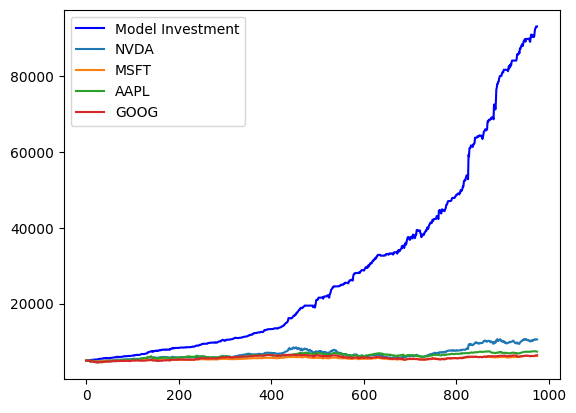

In [97]:
#Plot the graph of wealth
plt.plot(values,color='b',label="Model Investment")

 
#Plot for each company

for i in range(len(companies)):
    print(companies[i])
    plt.plot(forgot_price[:,i],label=companies[i])

plt.legend()

In [71]:
#NOW for testing data
#Extracting Data
companies = ["NVDA","MSFT","AAPL","GOOG"]
#Getting ticker object

data_standard_test = []
for c in companies:
    ticker = yf.Ticker(c)

    #Get historic data for the last 5 years
    history = ticker.history(start="2024-1-01",actions=True)

    #Extract open,volume and dividends
    stock_data = history[["Open","Volume"]]

  

    #Convert to numpy
    data_standard_company = stock_data.to_numpy()

    #And concat it with the rest
    if(len(data_standard_test)>0):
        data_standard_test = np.concatenate((data_standard_test,data_standard_company),axis =1)
    else:
        data_standard_test = data_standard_company

#Now we standardize the values
mean = data_standard_test.mean(axis=0)
std = data_standard_test.std(axis=0)
data_standard_test = (data_standard_test-mean)/(std)

print(data_standard_test)

[[-2.54327358  0.45951224 -1.87904169 ...  0.86560311 -1.82688535
  -0.11416413]
 [-2.61225078 -0.12120982 -2.06394104 ...  0.03139578 -1.89003231
  -0.22930539]
 [-2.60119242 -0.21350656 -2.00065671 ...  0.50158555 -1.81109684
  -0.30494027]
 ...
 [ 1.73991506 -0.9330285   3.03216425 ...  1.19216239  0.84175474
   2.3922458 ]
 [ 1.65713703 -0.81372398  3.01018665 ...  0.73739946  0.58892829
   0.4844739 ]
 [ 1.5272816  -1.08525483  2.76033883 ...  0.35985396  0.57241238
  -0.1950966 ]]


In [72]:
X_test,_ = create_dataset(data_standard_test,lookback)
print(X_test.shape)

torch.Size([345, 30, 8])


[1.4338969 1.3437699 1.3259891]


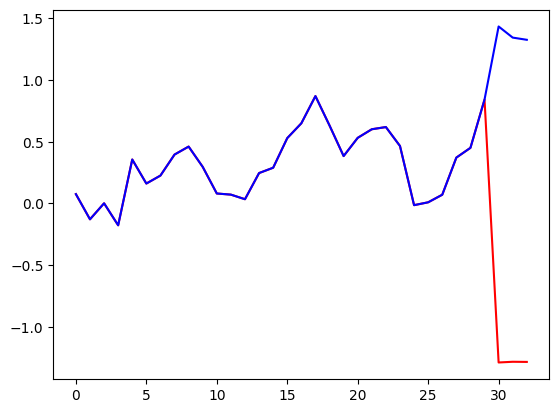

In [110]:
lookahead = 3
#Display sample graph
company_id = 3


index = -1

inp = X_test[index]

combined = inp[:,company_id*2].numpy()
actual = data_standard[index + lookback:index+lookback+lookahead,company_id*2]
generated = generate_sequence(inp,trader,lookahead)[:,company_id*2]
real = np.concatenate((combined,actual))
predicted = np.concatenate((combined,generated))

print(generated)

plt.plot(real,color='r')
plt.plot(predicted,color='b')

In [107]:
#Testing Simulation
#Simulating the market for training
money = 5000
stocks = [0,]*len(companies)

values = []

price_history = []

for x in X_test:
    price_indices = x[:,[2*i for i in range(0,len(companies))]]
    means = mean[[2*i for i in range(0,len(companies))]]
    stds = std[[2*i for i in range(0,len(companies))]]

    #Actual last price
    prices = (price_indices*stds+means).numpy()[-1]
    
    predictions = generate_sequence(x,trader,3)[:,[2*i for i in range(0,len(companies))]]
    predicted_indices = np.mean(predictions,axis=0)
    predicted = predicted_indices*stds+means
    changes = (predicted-prices)/prices
    

    contri  = [] 
    div = 0
    #We sell all the stocks which are going down and calculate how much to reinvest
    for i in range(len(changes)):
        #If there is a positive change
        if(changes[i]>0):
            contri.append(changes[i])
            div += changes[i]
        else:
            #Stock is going down... Sell it 
            money += stocks[i]*prices[i]
            stocks[i] = 0
            contri.append(0)

    if(div!=0):
        spent = 0
        #Reinvest money
        for i in range(len(contri)):
            #Money to invest
            m = (contri[i]/div)*money
            new_stocks = (m//prices[i])
            stocks[i] += new_stocks
            spent += new_stocks*prices[i]
        money -= spent
    
    #Compute valuation
    val = money + np.multiply(stocks,prices).sum()
    values.append(val)

    price_history.append(prices)

print(val)



C:\Users\Dell\AppData\Local\Temp\ipykernel_17684\3931601391.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  prices = (price_indices*stds+means).numpy()[-1]


13217.332808590332


In [108]:
#Computing what would happen if we just invested and "forgot" about our holdings
forget_stocks = 5000/(price_history[0])
forgot_price= np.multiply(price_history,forget_stocks)


NVDA
MSFT
AAPL
GOOG


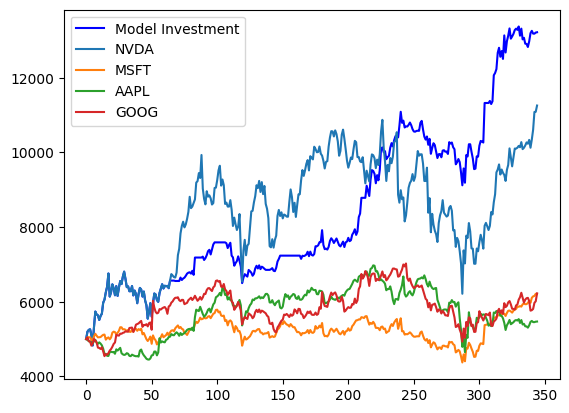

In [109]:
#Plot the graph of wealth
plt.plot(values,color='b',label="Model Investment")

 
#Plot for each company

for i in range(len(companies)):
    print(companies[i])
    plt.plot(forgot_price[:,i],label=companies[i])

plt.legend()

In [20]:
torch.save(trader.state_dict(),"Trader.pt")